In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import iqr
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rc('figure',figsize=(14,8))

In [3]:
df = pd.read_csv('lemonade.csv', index_col=0)
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [4]:
def get_lower_and_upper_bounds(series, k = 1.5):
    upper_bound = np.percentile(series, 75) + k * iqr(series)
    lower_bound = np.percentile(series, 25) - k * iqr(series)
    return round(upper_bound, 5), round(lower_bound, 5)

In [5]:
upper, lower = get_lower_and_upper_bounds(df.Temperature)
df[df.Temperature < lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
364,12/31/17,Sunday,15.1,2.5,9,0.5,7


In [6]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col])
    print(df[col][df[col] < lower].to_list())

[15.1]
[]
[-38]
[]
[]


In [7]:
df.Flyers.nsmallest(5)

324   -38
364     9
338    11
0      15
1      15
Name: Flyers, dtype: int64

This is almost certainly a typo or some other mistake for flyers, and should be dropped. the temperature outlier is not far from the lower bound and can stay

In [8]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col])
    print(df[col][df[col] > upper].to_list())

[212.0]
[2.0, 1.33, 1.33, 1.54, 1.54, 1.54, 1.33, 1.33, 1.67, 1.43, 1.43, 1.54, 1.33, 1.33, 1.54, 1.82, 1.43, 1.82, 1.33, 1.43, 1.54, 1.33, 1.43, 1.33, 1.54, 1.43, 1.43, 2.5]
[77, 80]
[]
[235, 534, 99, 87]


In [9]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col])
    print((col, upper))

('Temperature', 104.7)
('Rainfall', 1.3)
('Flyers', 76.0)
('Price', 0.5)
('Sales', 45.0)


Rainfall outliers seem to make sense and we can keep them, but Temperature and Sales are massive outliers and should be dropped

In [10]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col], k=3)
    print(df[col][df[col] < lower].to_list())

[]
[]
[-38]
[]
[]


A negative number here makes no sense at all, and should be dropped

In [11]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col], k=3)
    print(df[col][df[col] > upper].to_list())

[212.0]
[2.0, 1.82, 1.82, 2.5]
[]
[]
[235, 534, 99, 87]


In [12]:
for col in df.select_dtypes('number').columns:
    upper, lower = get_lower_and_upper_bounds(df[col], k=3)
    print((col, upper))

('Temperature', 137.7)
('Rainfall', 1.69)
('Flyers', 103.0)
('Price', 0.5)
('Sales', 60.0)


The temperature and at least the 2 highest sales should be dropped because they are so far away from the upper bound. The lower 2 sales and Rainfall seem feasible so they should be kept

In [13]:
scaler = MinMaxScaler()
df2 = pd.DataFrame(scaler.fit_transform(df.select_dtypes('number')),
                    columns=df.select_dtypes('number').columns)
df2 = df2.drop(columns=['Price','Sales'])
df2

,Temperature,Rainfall,Flyers
0,0.060437,0.761905,0.449153
1,0.070086,0.442857,0.449153
2,0.098527,0.442857,0.550847
3,0.147283,0.309524,0.559322
4,0.138649,0.285714,0.601695
...,...,...,...
360,0.140173,0.285714,0.601695
361,0.115287,0.404762,0.593220
362,0.123921,0.404762,0.466102
363,0.080244,0.490476,0.508475


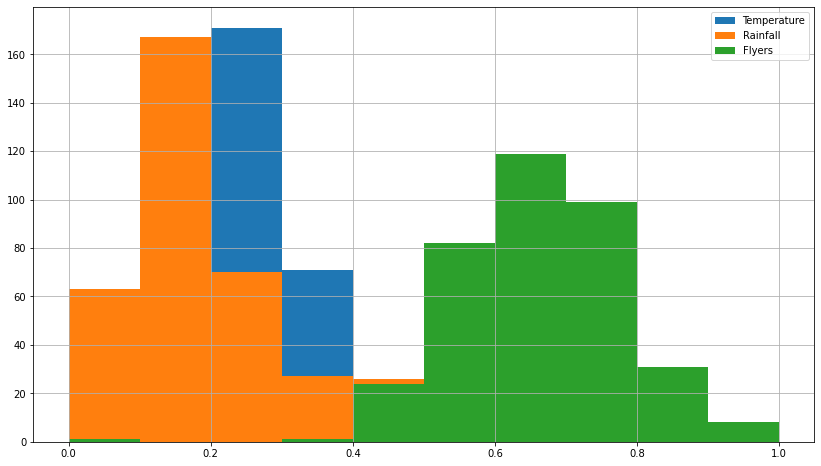

In [14]:
for col in df2.columns:
    df2[col].hist(label=col)
plt.legend()

In [15]:
for col in df[['Temperature','Rainfall','Flyers']].columns:
    zscores = (df[col] - df[col].mean()) / df[col].std()
    print((col, df[col][zscores.abs() >= 2].to_list()))

('Temperature', [212.0, 99.3, 102.6, 102.9, 98.0, 99.3, 99.6, 97.9, 22.0, 15.1])
('Rainfall', [2.0, 1.54, 1.54, 1.54, 1.67, 1.43, 1.43, 1.54, 1.54, 1.82, 1.43, 1.82, 1.43, 1.54, 1.43, 1.54, 1.43, 1.43, 2.5])
('Flyers', [77, 70, 76, 68, 68, 80, 76, 72, 69, 74, -38, 11, 9])


Many of these values are relatively normal, and should not be dropped

In [16]:
for col in df[['Temperature','Rainfall','Flyers']].columns:
    zscores = (df[col] - df[col].mean()) / df[col].std()
    print((col, df[col][zscores.abs() >= 3].to_list()))

('Temperature', [212.0])
('Rainfall', [2.0, 1.67, 1.82, 1.82, 2.5])
('Flyers', [-38])


These are much closer to what I would expect an outlier to need to be to drop it, although I still think Rainfall should not be dropped, except possibly the largest value. This would require research.